# Curso: Redes Neurais e Deep Learning

Prof. Denilson Alves Pereira
https://sites.google.com/ufla.br/denilsonpereira/
Departamento de Ciência da Computação -
Instituto de Ciências Exatas e Tecnológicas -
Universidade Federal de Lavras

# Atividade Prática 02

**Instruções:**
1. Siga os passos indicados em cada célula abaixo para completar a atividade.
2. Você deve inserir código somente entre as linhas marcadas com **INICIE O CÓDIGO AQUI** e **TERMINE O CÓDIGO AQUI**. Há uma indicação de quantas linhas de código são necessárias.
3. Em alguns pontos, confira o resultado esperado conforme marcado com **SAÍDA ESPERADA**.

**Tempo estimado para execução**: 1 hora

Versão: Junho, 2021

## O Problema a ser Resolvido

O objetivo da atividade é elaborar uma rede neural para predizer se o animal de uma imagem é um gato ou um cachorro. <br>

Será usado um dataset contendo 8.000 imagens para treinamento e 4.000 para teste, sendo a metade delas de gatos e a outra metade, de cachorros. As imagens têm tamanhos diversos e estão no formato RGB.

Você vai praticar as seguintes habilidades:
- Ler arquivos de imagens e convertê-los para vetores de pixels
- Utilizar um gerador de dados aumentados para expandir o conjunto de imagens para treinamento da rede
- Configurar uma rede neural simples para um problema de classificação multiclasse de imagens. Embora só existam duas classes, a saída será configurada para predizer "cat" se a imagem é de um gato ou "dog" se a imagem é de um cachorro.

É importante destacar que a arquitetura de rede neural utilizada no nesta atividade **não** é a mais indicada para classificar imagens. Para uma melhor eficácia, devem ser adicionadas algumas camadas de Redes Neurais Convolucionais (CNN), que é assunto do próximo curso.

## Pacotes

In [1]:
!pip install --upgrade pip
!pip install tensorflow
!pip install pandas
!pip install keras_preprocessing
!pip install matplotlib

In [2]:
# Importei o dataset diretamente do Kaggle para poder usar com mais facilidade o Google Colab

!kaggle datasets download -d d4rklucif3r/cat-and-dogs -p /content/
!unzip -o /content/cat-and-dogs.zip -d /content/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset/training_set/cats/cat.37.jpg  
  inflating: /content/dataset/training_set/cats/cat.370.jpg  
  inflating: /content/dataset/training_set/cats/cat.3700.jpg  
  inflating: /content/dataset/training_set/cats/cat.3701.jpg  
  inflating: /content/dataset/training_set/cats/cat.3702.jpg  
  inflating: /content/dataset/training_set/cats/cat.3703.jpg  
  inflating: /content/dataset/training_set/cats/cat.3704.jpg  
  inflating: /content/dataset/training_set/cats/cat.3705.jpg  
  inflating: /content/dataset/training_set/cats/cat.3706.jpg  
  inflating: /content/dataset/training_set/cats/cat.3707.jpg  
  inflating: /content/dataset/training_set/cats/cat.3708.jpg  
  inflating: /content/dataset/training_set/cats/cat.3709.jpg  
  inflating: /content/dataset/training_set/cats/cat.371.jpg  
  inflating: /content/dataset/training_set/cats/cat.3710.jpg  
  inflating: /content/dataset/training_set/cats/cat.3711.jpg  


In [3]:
import os
import shutil

TESTDIR = "/content/dataset/test_set"
TRAININGDIR = "/content/dataset/training_set"

cats_dir = os.path.join(TESTDIR, 'cats')
dogs_dir = os.path.join(TESTDIR, 'dogs')

def move_files_to_parent(src_dir, parent_dir):
    for filename in os.listdir(src_dir):
        src_file = os.path.join(src_dir, filename)
        dest_file = os.path.join(parent_dir, filename)
        if os.path.isfile(src_file):
            shutil.move(src_file, dest_file)

move_files_to_parent(cats_dir, TESTDIR)
move_files_to_parent(dogs_dir, TESTDIR)

os.rmdir(cats_dir)
os.rmdir(dogs_dir)

print("Arquivos movidos e pastas removidas com sucesso!")

cats_dir = os.path.join(TRAININGDIR, 'cats')
dogs_dir = os.path.join(TRAININGDIR, 'dogs')

move_files_to_parent(cats_dir, TRAININGDIR)
move_files_to_parent(dogs_dir, TRAININGDIR)

os.rmdir(cats_dir)
os.rmdir(dogs_dir)

Arquivos movidos e pastas removidas com sucesso!


In [4]:
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator, load_img
import pandas as pd
import matplotlib.pyplot as plt
import random

d4rklucif3r_cat_and_dogs_path = kagglehub.dataset_download('d4rklucif3r/cat-and-dogs') # Link mencionado posteriormente no documento

## Inicializações

In [15]:
IMAGE_WIDTH = 128  # largura da imagem
IMAGE_HEIGHT = 128 # altura da imagem
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) # tamanho da imagem
IMAGE_CHANNELS = 3  # número de canais RGB da imagem
DIR_TRAIN = "/content/dataset/training_set/"  # Diretório contendo dados de treinamento
DIR_TEST = "/content/dataset/test_set/"  # Diretório contendo dados de teste

## Pré-Processamento dos Dados de Treino e de Teste

Fonte: https://www.kaggle.com/d4rklucif3r/cat-and-dogs

### Treino

In [16]:
# Read the images from the training directory and generates a pandas structure with the name of each file and the class of the image (cat or dog)
filenames = os.listdir(DIR_TRAIN)
categories = []
for filename in filenames:
    categories.append(filename.split('.')[0]) # category = initial part of the file name

df_train = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [17]:
df_train.head()

,filename,category
0,dog.3011.jpg,dog
1,dog.640.jpg,dog
2,cat.424.jpg,cat
3,dog.3043.jpg,dog
4,dog.3764.jpg,dog


In [18]:
df_train.tail()

,filename,category
7995,cat.1165.jpg,cat
7996,cat.2502.jpg,cat
7997,dog.3654.jpg,dog
7998,dog.3316.jpg,dog
7999,cat.2893.jpg,cat


<Axes: xlabel='category'>

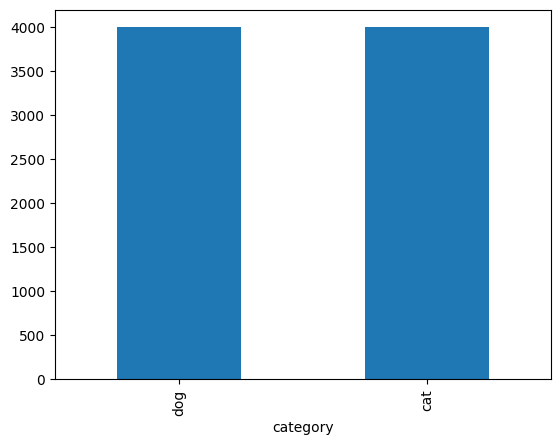

In [19]:
# number of cats and dogs
df_train['category'].value_counts().plot.bar()

#### Exibe uma amostra

Text(0.5, 1.0, 'dog.1687.jpg')

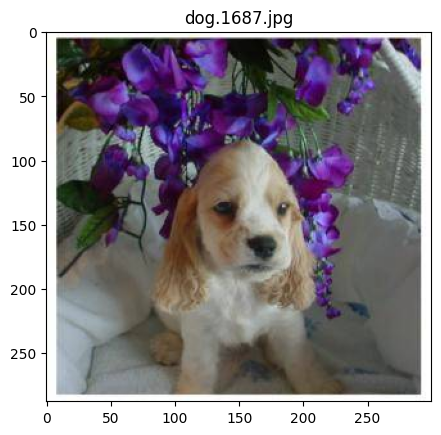

In [20]:
# Randomly chooses a file and displays its image
sample = random.choice(filenames)
image = load_img(DIR_TRAIN+sample)
plt.imshow(image)
plt.title(sample)

In [21]:
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)

JPEG
RGB
(300, 288)


### Representação de imagens RGB

![imagem-rgb.png](attachment:imagem-rgb.png)

Em imagens coloridas, o padrão RGB (Red, Green, Blue) representa cada pixel como um vetor de três números para os três canais das cores primárias vermelho, verde e azul. Cada número varia de 0 a 255, representando a intensidade da cor correspondente. O três valores combinados formam a cor do pixel. Por exemplo, a cor violeta pode ser representada como 128, 0, 128, uma mistura de intensidade moderada de vermelho e azul, sem o verde.

Já em imagens em escala de cinza (*grayscale*), cada pixel é representado com um único número (entre 0 e 255), o qual determina o quão preto é o pixel (0 é preto e 255 é branco brilhante).

In [22]:
# convert image to numpy array
data = np.asarray(image)
# summarize shape
print(data.shape)

(288, 300, 3)


### Teste

In [23]:
# Read the images from the test directory and generates a pandas structure with the name of each file and the class of the image (cat or dog)
filenames = os.listdir(DIR_TEST)
categories = []
for filename in filenames:
    categories.append(filename.split('.')[0]) # category = file name

df_test = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [24]:
df_test.head()

,filename,category
0,cat.4713.jpg,cat
1,dog.4109.jpg,dog
2,dog.4493.jpg,dog
3,dog.4814.jpg,dog
4,cat.4171.jpg,cat


In [25]:
df_test.tail()

,filename,category
1995,dog.4295.jpg,dog
1996,cat.4079.jpg,cat
1997,dog.4407.jpg,dog
1998,dog.4563.jpg,dog
1999,cat.4731.jpg,cat


<Axes: xlabel='category'>

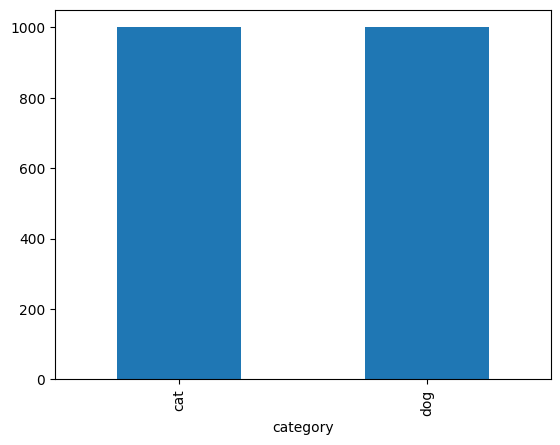

In [26]:
# number of cats and dogs
df_test['category'].value_counts().plot.bar()

#### Exibe uma amostra

Escolha um arquivo aleatório do conjunto de teste e exiba sua imagem

Text(0.5, 1.0, 'dog.4878.jpg')

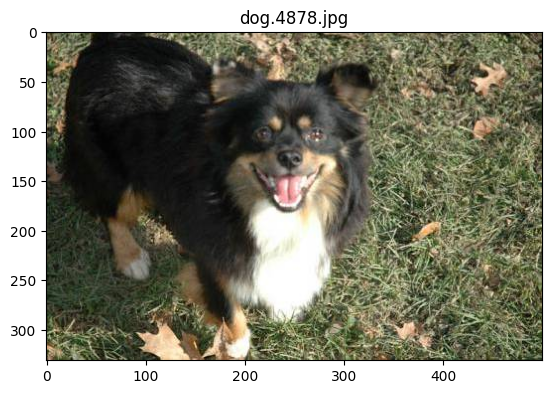

In [27]:
# Randomly chooses a file and displays its image
### INICIE O CÓDIGO AQUI ### (4 linhas de código)
sample = random.choice(filenames)
image = load_img(DIR_TEST+sample)
plt.imshow(image)
plt.title(sample)
### TERMINE O CÓDIGO AQUI ###

### Data Augmentation

*Data Augmentation* (aumento de dados) é uma técnica usada para expandir artificialmente o conjunto de dados de treinamento. Ela ajuda a evitar o problema de *overfitting*, que faz com que o modelo de treinamento fique muito ajustado aos dados usados para o treinamento, e não gera um bom desempenho em outros conjuntos de dados.

No caso das imagens de gatos e cachorros, a ideia é alterar os dados de treino com pequenas transformações nas imagens, de forma a reproduzir as variações que ocorrem quando alguém tira uma foto. Por exemplo, centralização, diferentes escalas (gatos/cachorros grandes e pequenos), a imagem está rotacionada etc. Além disso, o dataset contém imagens de tamanhos diferentes, e precisam ser padronizadas para dar entrada na rede neural.

As abordagens para *data augmentation* alteram os dados de treino de forma a mudar a representação vetorial, mas mantendo o mesmo rótulo de classe. Algumas transformações populares são: grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, shift, brightness, and zoom..

Fazendo algumas dessas transformações nos dados de treino, é possível multiplicar o número de exemplos de treino, de forma a criar um modelo mais robusto.

Tutorial para configurar *data augmentation* de imagens em Keras: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Generador de Treino

Documentação: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Este exemplo foi adaptado de https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification. <br>

In [28]:
batch_size = 15
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Takes the dataframe and the path to a directory and generates batches.
# The generated batches contain augmented/normalized data.
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    DIR_TRAIN,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 8000 validated image filenames belonging to 2 classes.


### Generador de Teste

Um gerador de dados pode também ser usado para especificar o dataset de validação e o dataset de teste. Normalmente, uma instância separada de ImageDataGenerator é criada para que se possa configurar a mesma escala de pixels que aquela usada na instância ImageDataGenerator do dataset de treinamento, mas ela não usará *data augmentation*. Isso ocorre porque *data augmentation* é somente usada como uma técnica para expandir artificialmente o dataset de treinamento, para se melhorar o desempenho de um dataset menor.

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR_TEST,
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


### Exemplo das Imagens Aumentadas

In [30]:
df_example = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example,
    DIR_TRAIN,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


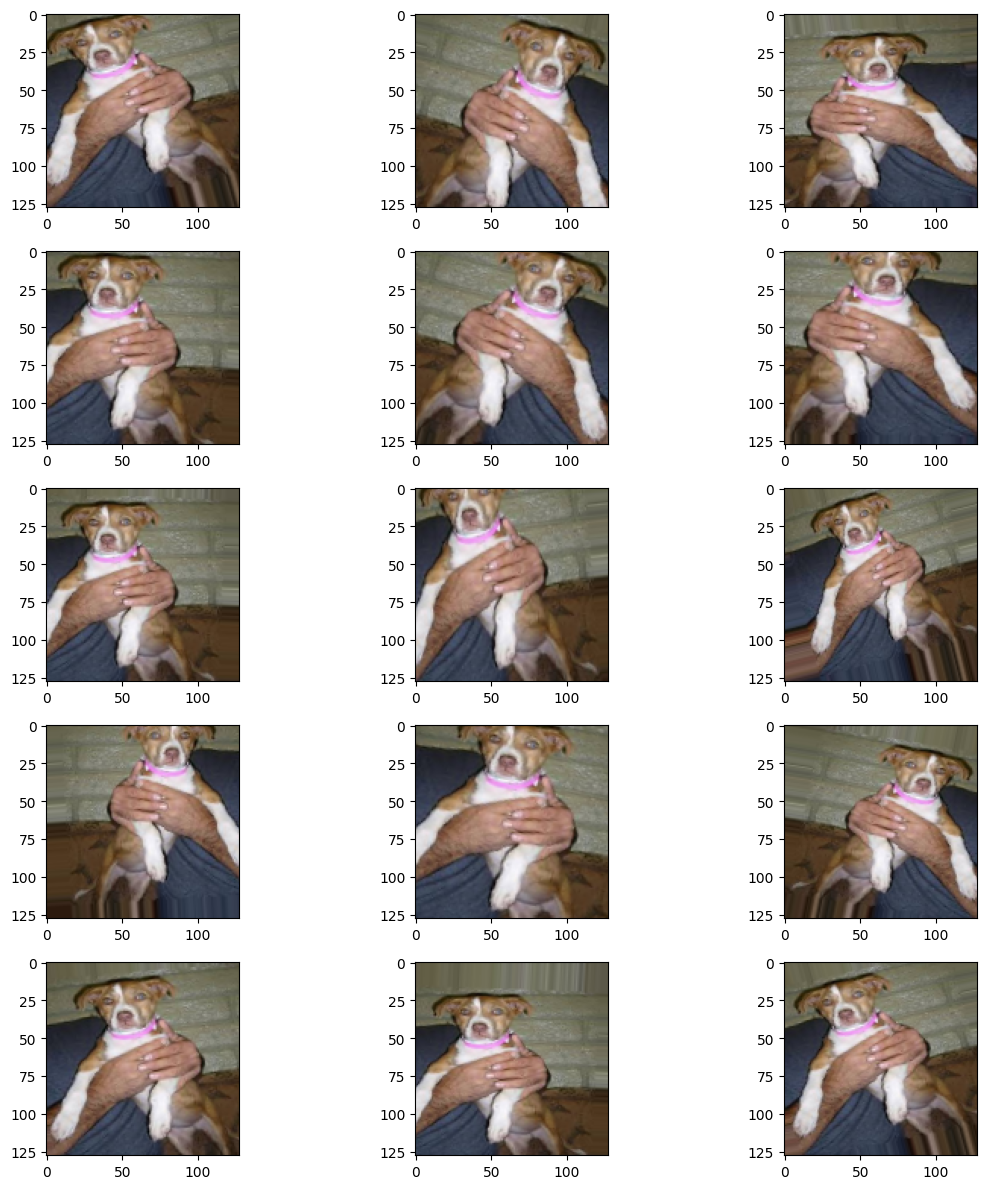

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Definição do Modelo

Crie um modelo em Keras com a seguinte configuração:
- Camada de entrada: no formato dos dados de entrada do problema
- Camada *Flatten*: camada para achatar o vetor de entrada. No padrão RGB, cada imagem é representada como um vetor de 3 dimensões. Entretanto, cada entrada em uma rede neural é composta por um vetor de apenas uma dimensão. Assim, é necessário "achatar" o vetor da imagam para uma dimensão. Isso é feito pela camada *Flatten*, que cria um vetor de uma dimensão concatenando sequencialmente os valores nos vetores dos três canais da imagem. Desta forma, se o vetor imagem tem o formato (128, 128, 3), por exemplo, o vetor achatado terá dimensão (49.152, 1), o resultado de 128 x 128 x 3.
- Camada 1: 32 neurônios, função de ativação *ReLu*
- Camada 2: 64 neurônios, função de ativação *ReLu*
- Camada 3: 32 neurônios, função de ativação *ReLu*
- Camada 4 (saída): 2 neurônios, função de ativação *Softmax*. Embora tenha apenas duas classes, o problema deve ser modelado como uma classificação multiclasse ("cat" ou "dog"). Assim, a camada de saída deve ter duas unidades e usar a função Softmax.

Documentação: <br>
Keras: https://keras.io/ <br>
Flatten layer: https://keras.io/api/layers/reshaping_layers/flatten/ <br>
Classe *Model*: https://keras.io/api/models/model/ <br>
Funções de ativação disponíveis: https://keras.io/api/layers/activations/

In [33]:
### INICIE O CÓDIGO AQUI ### (7 linhas de código)
inputs = keras.Input(shape=(128,128,3))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(units=32, activation="relu")(x)
x = keras.layers.Dense(units=64, activation="relu")(x)
x = keras.layers.Dense(units=32, activation="relu")(x)
outputs = keras.layers.Dense(units=2, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
### TERMINE O CÓDIGO AQUI ###

In [34]:
# Prints a summary of the network, showing its architecture and parameters.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       1,572,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,577,154 (6.02 MB)

 Trainable params: 1,577,154 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

**SAÍDA ESPERADA**: <br>
Confira a configuração da rede e o total de parâmetros = 1,577,154

---

## Compilação do Modelo

Compile o model usando os seguintes parâmetros:
- Função de perda: categorical_crossentropy
- Otimizador: adam
- Métricas: accuracy

Dica 1: use a função *compile*: https://keras.io/api/models/model_training_apis/ <br>
Dica 2: relação de funções de perda: https://www.tensorflow.org/api_docs/python/tf/keras/losses <br>
Dica 3: relação de otimizadores: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers <br>
Dica 4: relação de métricas: https://keras.io/api/metrics/

In [35]:
### INICIE O CÓDIGO AQUI ### (1 linha de código)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
### TERMINE O CÓDIGO AQUI ###

## Treinamento do Modelo

Ajusta o modelo aos dados de treinamento.
Devem ser fornecidos os dados de treinamento e o número de épocas (iterações). Uma época é composta por uma única passagem por todos os exemplos do conjunto de treino.

Efetue o treinamento do modelo usando 3 épocas com os dados aumentados do gerador de treino *train_generator*.

Dica: use a função *fit*: https://keras.io/api/models/model_training_apis/

In [36]:
### INICIE O CÓDIGO AQUI ### (1 linha de código)
history = model.fit(train_generator, epochs = 3)
### TERMINE O CÓDIGO AQUI ###
print(history.history)  # print per-epoch timeseries of metrics values

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


534/534 ━━━━━━━━━━━━━━━━━━━━ 80s 145ms/step - accuracy: 0.5210 - loss: 1.2575
Epoch 2/3
534/534 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - accuracy: 0.5088 - loss: 0.6962
Epoch 3/3
534/534 ━━━━━━━━━━━━━━━━━━━━ 72s 118ms/step - accuracy: 0.5037 - loss: 0.6911
{'accuracy': [0.518625020980835, 0.5052499771118164, 0.5117499828338623], 'loss': [0.9197410345077515, 0.6932596564292908, 0.6913354992866516]}


**SAÍDA ESPERADA**: <br>
Na época 3, tem-se o seguinte resultado (aproximado): <br>
{'loss': [0.8931004405021667, 0.6976273059844971, 0.6935341954231262], 'accuracy': [0.5130000114440918, 0.5195000171661377, 0.5037500262260437]}

---

## Avaliação do Modelo

Avalie o desempenho da rede no conjunto de teste usando o gerador de dados aumentados *test_generator*.

Dica: use a função *evaluate*: https://keras.io/api/models/model_training_apis/

In [38]:
### INICIE O CÓDIGO AQUI ### (1 linha de código)
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
### TERMINE O CÓDIGO AQUI ###
print("Loss: %.2f" % loss, "\nAccuracy: %.2f" % acc)

134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5078 - loss: 0.6930
Loss: 0.69 
Accuracy: 0.50


**SAÍDA ESPERADA**: <br>
Valores aproximados:

Loss: 0.69 <br>
Accuracy: 0.50

---

## Predição

Apresente a predição do conjunto de teste usando o gerador de dados aumentados *test_generator*.

Documentação: <br>
Função *predict*: https://keras.io/api/models/model_training_apis/ <br>
Função *argmax*: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html

Na classificação multiclasse, *model.predict* retorna um vetor de probabilidades para cada classe. A função *argmax* retorna o índice do vetor com a maior probabilidade, neste caso, 0 para gato e 1 para cachorro.

In [40]:
### INICIE O CÓDIGO AQUI ### (1 linha de código)
predictions = model.predict(test_generator)
### TERMINE O CÓDIGO AQUI ###
preds = [np.argmax(x, axis=-1) for x in predictions]
print("Predictions: ", ["cat" if x == 0 else "dog" for x in preds[:30]]) # print the first 30 predictions
print("\nCorrect:     ", [x for x in df_test['category'][:30]])

134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step
Predictions:  ['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog']

Correct:      ['cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog']


**SAÍDA ESPERADA**: <br>
Valores aproximados: <br>
Predictions:  ['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog']

Correct:      ['dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']

---

# Fim

Esses foram os passos para criação de uma rede neural simples para classificação de imagens. Lembrando que para se obter uma melhor eficácia, devem ser adicionadas algumas camadas de Redes Neurais Convolucionais (CNN), que é assunto do próximo curso.

-------------------------------------------